# 📚 Fake News Detection with Machine Learning

## Project Overview
This project focuses on the automatic detection of fake news using text data.  
The goal is to build a model with Natural Language Processing (NLP and Machine Learning (ML) that can classify news articles as either real or fake.

The dataset is sourced from [Kaggle](https://www.kaggle.com/code/therealsampat/fake-news-detection/input?select=Fake.csv) and includes both real and fake news articles.

The project covers the following steps:

- Data import and merging  
- Exploratory Data Analysis (EDA)  
- Text preprocessing and feature extraction  
- Model training using Random Forest  
- Evaluation and interpretation of results

The pipeline is designed to be as clear, reproducible, and easy to follow as possible.


## Setup & Data

### Install & Import Packages
We start by installing and importing all the necessary libraries for data analysis, visualization, and machine learning.  
Additionally, we use `gdown` to download the CSV files directly from Google Drive.

In [ ]:
# Optional: Install gdown if running locally or for the first time
!pip install -q gdown

# Packages for data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Tool for downloading files from Google Drive
import gdown


### Download & Load Data
The dataset consists of two files containing real and fake news articles.  
We download them directly from Google Drive using their file IDs, read them into dataframes, and label them as follows:

- `0` = Real news  
- `1` = Fake news

In [ ]:
# IDs of the CSV files stored in Google Drive
true_file_id = "15C_WRtKOjRhKVbZDvqj5o-XQAw4YAwX_"
fake_file_id = "19NNkzWwreIsIAmWePIk4XxQtiVG2jq9r"

# Download the CSV files using gdown
gdown.download(f"https://drive.google.com/uc?id={true_file_id}", "True.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={fake_file_id}", "Fake.csv", quiet=False)

# Read the CSVs into DataFrames
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

# Assign binary labels: 0 = real, 1 = fake
true_df["label"] = 0
fake_df["label"] = 1


Downloading...
From: https://drive.google.com/uc?id=15C_WRtKOjRhKVbZDvqj5o-XQAw4YAwX_
To: /content/True.csv
100%|██████████| 53.6M/53.6M [00:00<00:00, 86.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=19NNkzWwreIsIAmWePIk4XxQtiVG2jq9r
To: /content/Fake.csv
100%|██████████| 62.8M/62.8M [00:00<00:00, 66.5MB/s]


## Exploratory Data Analysis (EDA)

In the first part of the analysis, we calculate the word count per article to examine whether there are notable differences in text length between real and fake news.

Next, we visualize the most frequently used words using word clouds.

To ensure compatibility without relying on external libraries like `nltk`, we define a custom stopword list.


### Text Length Distribution

To begin our analysis, we merge the datasets and compute the number of words per article.  
We then visualize the distribution of text lengths to see if there are noticeable differences between real and fake news.

A custom stopword list is defined for later use in WordClouds, allowing us to work without dependencies like `nltk`.


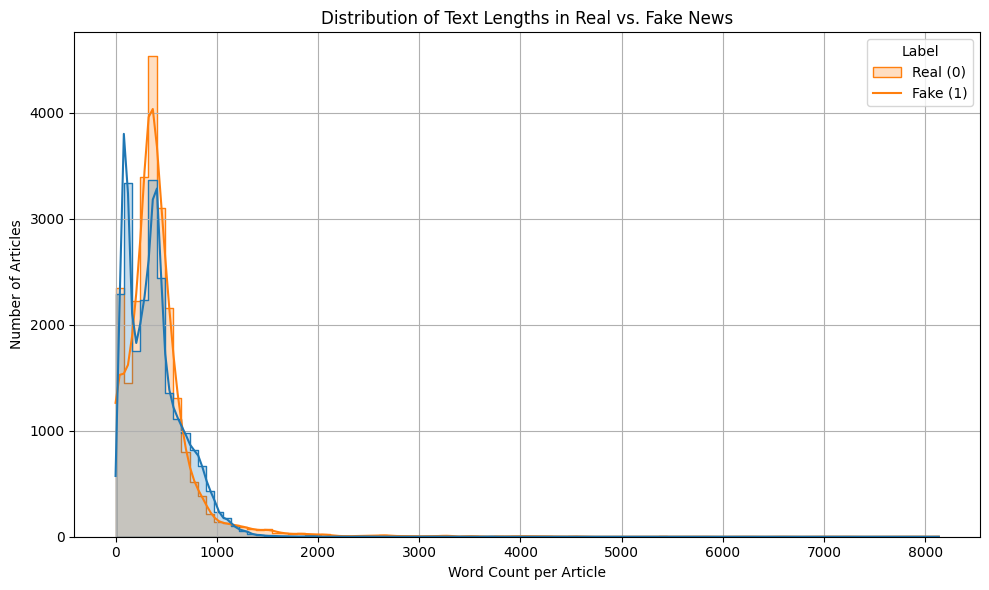

In [ ]:
# Custom stopword list (offline-friendly, no nltk dependency)
basic_stopwords = {
    "the", "and", "to", "of", "a", "in", "that", "is", "for", "on", "with",
    "as", "was", "at", "by", "an", "be", "this", "have", "from", "or", "it",
    "are", "not", "has", "but", "had", "they", "you", "he", "she", "we", "will",
    "their", "his", "her", "about", "would", "there", "what", "when", "which",
    "who", "were", "can", "them", "all", "been", "one", "if"
}

# Combine both datasets (already labeled)
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

# Calculate word count per article
combined_df["text_length"] = combined_df["text"].apply(lambda x: len(str(x).split()))

# Plot distribution of text lengths by label
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="text_length", hue="label", bins=100, kde=True, element="step")
plt.title("Distribution of Text Lengths in Real vs. Fake News")
plt.xlabel("Word Count per Article")
plt.ylabel("Number of Articles")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Interpretation**

The visualization shows the distribution of text lengths (word count) in real (`label = 0`) and fake (`label = 1`) news articles.

Fake news tends to be slightly shorter than real news. Both distributions are right-skewed, meaning most articles are relatively short, with some outliers above 5,000 words.

This may suggest that fake news is written to be more concise—possibly to trigger emotion or spread faster.

This insight could be valuable for later feature selection and model interpretation.


### Word Clouds for Keyword Visualization

To visualize frequently used terms in the articles, we generate WordClouds.  
These provide a quick, intuitive overview of the most common words appearing in fake vs. real news content.

To improve readability, we remove frequent but low-value words (stopwords).  
A custom, offline-friendly stopword list is used instead of external libraries.


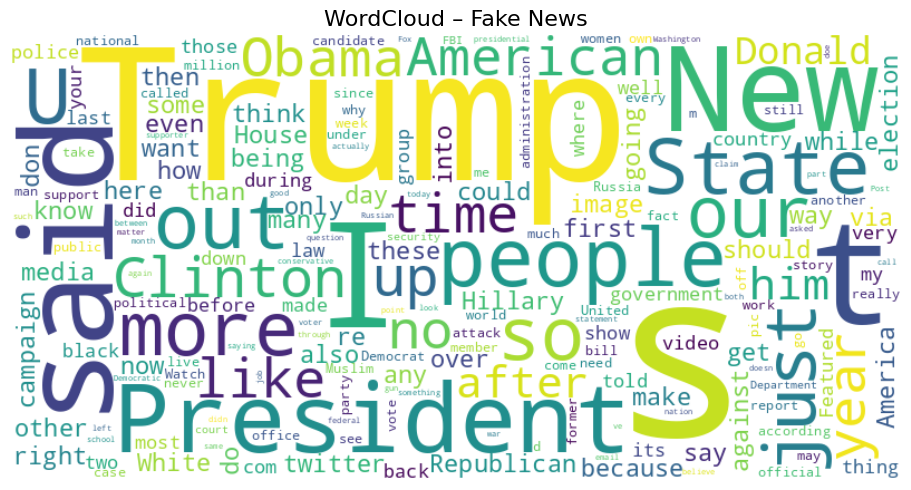

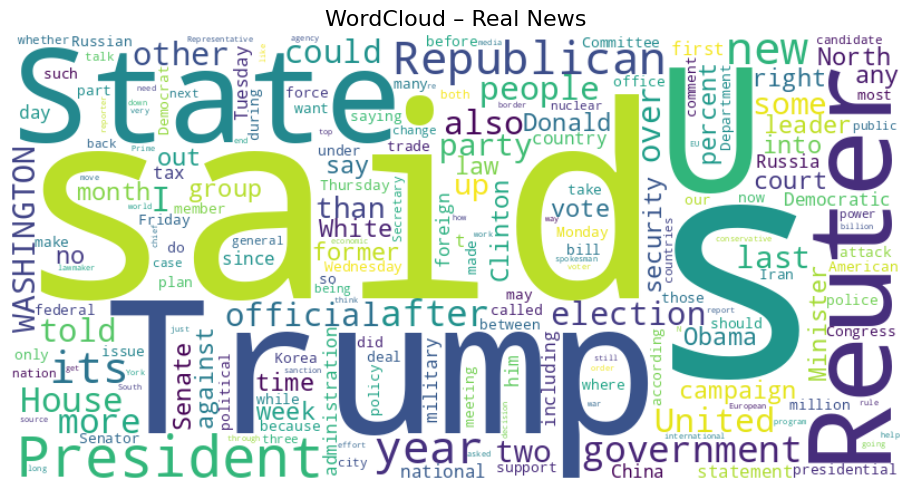

In [ ]:
# ☁️ Funktion zur Erstellung von WordClouds
def create_wordcloud(text, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=basic_stopwords,  # hier verwenden wir unsere eigene Liste
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 🔍 WordCloud für Fake News
create_wordcloud(" ".join(combined_df[combined_df["label"] == 1]["text"].dropna()), "WordCloud – Fake News")

# 🔍 WordCloud für Real News
create_wordcloud(" ".join(combined_df[combined_df["label"] == 0]["text"].dropna()), "WordCloud – Real News")

#### **Interpretation**

The two WordClouds show the most frequently used terms in fake news (top) and real news articles (bottom).

In both groups, common political terms such as `Trump`, `President`, `said`, and `state` dominate — indicating shared topical context. However, some clear differences emerge:

- In Fake News, words like `Clinton`, `Obama`, `Twitter`, `video`, `right`, and `hour` appear more often — some of which may carry emotional or time-sensitive framing.
- In Real News, terms such as `Reuters`, `official`, `court`, `government`, and `percent` are more prominent — suggesting a more institutional and formal tone.

These differences point to distinct language styles and thematic focus, which may serve as useful features for classification.


## Classification with Random Forest

In this step, we convert the text data into numerical features using TF-IDF vectorization.  
We then train a Random Forest classifier to distinguish between real and fake news articles.

The goal is to build a model that is robust, interpretable, and generalizes well to unseen data.


In [ ]:
# Define features (text) and target variable (label)
X = combined_df["text"].astype(str)
y = combined_df["label"]

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_tfidf)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9973273942093541

Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4330
        Fake       1.00      1.00      1.00      4650

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
 [[4323    7]
 [  17 4633]]


### Model Evaluation & Interpretation

The model was trained using a Random Forest Classifier based on TF-IDF features.  
The following metrics show its performance on the test set:

- **Accuracy:** 99.73%  
  → Extremely high overall accuracy – the model correctly classifies nearly all articles.

- **Precision, Recall, F1-Score:** all at 1.00  
  → The model makes virtually no classification errors for either real or fake news.  
    Performance is balanced across both classes, indicating unbiased classification.

- **Confusion Matrix:**

  [[4323 7]

  [ 17 4633]]

→ Only 24 articles were misclassified in total (7 real as fake, 17 fake as real)  
→ This low error rate highlights the model’s stability and reliability.


## Text Cleaning & Feature Engineering

To improve the quality of the text data, we apply several preprocessing steps:  
removal of URLs, punctuation, case normalization, and whitespace cleanup.

We then generate additional text-based features that could be useful for classification:

- Number of exclamation marks (`!`) – may indicate emotional or exaggerated content  
- Ratio of uppercase letters – might reflect sensational headlines  
- Word count – as a measure of text length (complementing earlier analysis)

Finally, we analyze the statistical properties and correlations of these features with the target label (Real vs. Fake).


In [ ]:
import re
import numpy as np

# Function to clean text
def clean_text(text):
    text = str(text).lower()                         # Convert to lowercase
    text = re.sub(r"http\S+", "", text)              # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)             # Remove special characters and digits
    text = re.sub(r"\s+", " ", text).strip()         # Remove extra spaces
    return text

# Apply text cleaning to all articles
combined_df["clean_text"] = combined_df["text"].apply(clean_text)

# Drop rows with empty or null cleaned text
combined_df.dropna(subset=["clean_text"], inplace=True)
combined_df = combined_df[combined_df["clean_text"].str.strip() != ""]

# Remove duplicate articles based on cleaned text
combined_df.drop_duplicates(subset=["clean_text"], inplace=True)

# Generate new features from the raw and cleaned text
combined_df["num_exclamations"] = combined_df["text"].apply(lambda x: str(x).count("!"))

combined_df["upper_ratio"] = combined_df["text"].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)

combined_df["word_count"] = combined_df["clean_text"].apply(lambda x: len(x.split()))


### Statistical Analysis & Correlations

The following metrics provide insights into the distribution of the newly engineered text-based features.  
We're especially interested in whether certain properties — such as a high number of exclamation marks — show correlation with the "Fake" label.




 Descriptive Statistics:
          word_count  num_exclamations   upper_ratio
count  38564.000000      38564.000000  38564.000000
mean     398.060938          0.369645      0.043113
std      309.454430          1.424916      0.031943
min        1.000000          0.000000      0.007538
25%      214.000000          0.000000      0.030612
50%      364.000000          0.000000      0.037283
75%      505.000000          0.000000      0.047346
max     8044.000000        133.000000      0.882353

🔗 Correlations:
                      label  word_count  num_exclamations  upper_ratio
label             1.000000    0.069518          0.238285     0.047404
word_count        0.069518    1.000000          0.073968    -0.209599
num_exclamations  0.238285    0.073968          1.000000     0.113324
upper_ratio       0.047404   -0.209599          0.113324     1.000000


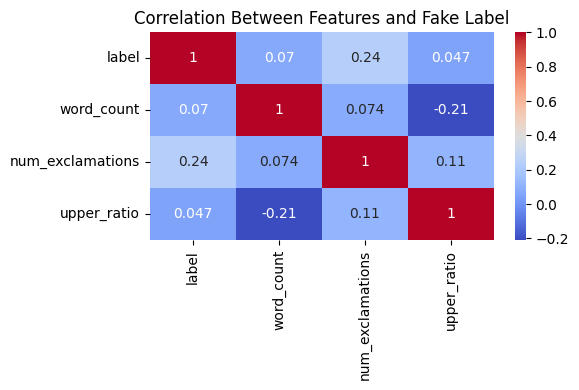

In [ ]:
# Show descriptive statistics for selected features
print("\n Descriptive Statistics:\n", combined_df[["word_count", "num_exclamations", "upper_ratio"]].describe())

# Compute correlation with the "Fake" label
correlation = combined_df[["label", "word_count", "num_exclamations", "upper_ratio"]].corr()
print("\n🔗 Correlations:\n", correlation)

# Visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between Features and Fake Label")
plt.tight_layout()
plt.show()


#### **Interpretation**

The correlation table shows how strongly our engineered features are associated with the "Fake News" label:

- A positive correlation with `num_exclamations` suggests that fake news articles tend to contain more exclamation marks.
- The `upper_ratio` is slightly higher for fake news, indicating a tendency to use more uppercase letters — possibly for sensational emphasis.
- Word count shows a weak negative correlation, which aligns with earlier observations: fake news articles are generally a bit shorter.

These findings help improve our understanding of the classification task and can guide further feature selection or refinement.


### Sentiment Analysis with VADER

In addition to traditional text features, we compute the sentiment of each article using the VADER Sentiment Analyzer from the `nltk` package.  
VADER is designed for social and news-style text, and returns a compound score ranging from -1 to +1, which summarizes the overall tone of the text:

- **Negative values** → indicate a more negative tone  
- **Positive values** → indicate a more positive tone


Die Berechnung erfolgt auf der zuvor bereinigten Textspalte `clean_text`.


In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (only needs to be done once)
nltk.download("vader_lexicon")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute compound sentiment score for each article
combined_df["sentiment"] = combined_df["clean_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Sentiment Score Distribution

The following visualization shows the distribution of sentiment scores, separated by fake and real news articles.  
This allows us to identify potential differences in tone between the two classes.


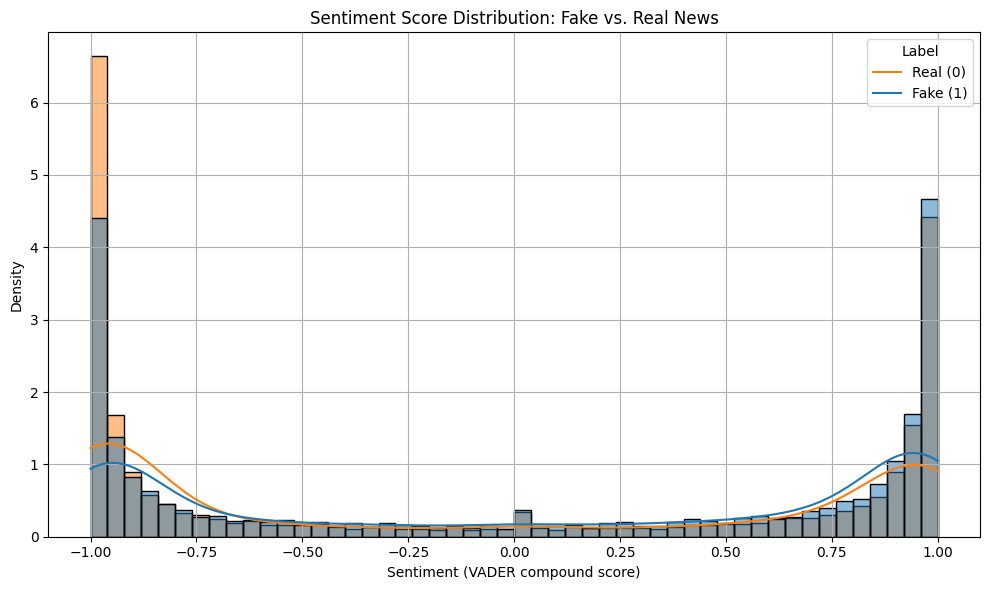

In [ ]:
# Visualize the distribution of sentiment scores for Fake vs. Real News
plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_df,
    x="sentiment",
    hue="label",
    bins=50,
    kde=True,
    stat="density",
    common_norm=False
)

plt.title("Sentiment Score Distribution: Fake vs. Real News")
plt.xlabel("Sentiment (VADER compound score)")
plt.ylabel("Density")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Interpretation**

The distribution of VADER sentiment scores shows a clear difference between fake and real news:

- Fake News (blue) display a more polarized distribution:
  - Many articles have extreme sentiment values (near `-1.0` or `+1.0`)
  - This suggests a tendency toward emotionally charged language

- Real News (orange) are more concentrated around neutral values,  
  though there are also some outliers at both ends

These patterns indicate that fake news may be designed to provoke emotional reactions, potentially as a form of manipulation or to attract attention.

➡️ As a result, sentiment appears to be a promising feature for distinguishing between fake and real news in classification models.


### Correlation Analysis & Feature Selection

Based on the engineered features (`word_count`, `num_exclamations`, `upper_ratio`, `sentiment`),  
we analyze how strongly each one correlates with the Fake News label.

The goal is to include only those features in the model that show a statistically relevant relationship to the target variable.

We select all features with an absolute correlation greater than 0.1,  
as a simple yet effective approach to feature selection.


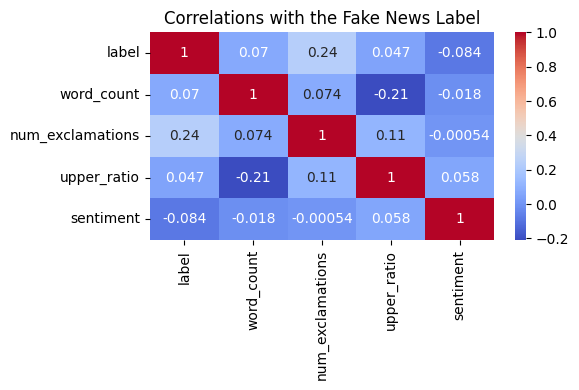

Selected Features for Modeling: ['num_exclamations']


In [ ]:
# Create a feature DataFrame including the label
feature_df = combined_df[["label", "word_count", "num_exclamations", "upper_ratio", "sentiment"]]

# Compute correlation matrix
corr_matrix = feature_df.corr()

# Visualize correlations with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlations with the Fake News Label")
plt.tight_layout()
plt.show()

# Select features with absolute correlation > 0.1
correlated_features = corr_matrix["label"].drop("label").abs()
selected_features = correlated_features[correlated_features > 0.1].index.tolist()

print("Selected Features for Modeling:", selected_features)


#### **Interpretation**

The correlation analysis reveals that among the examined features, only `num_exclamations` (number of exclamation marks) shows a meaningful correlation with the Fake News label (`r ≈ 0.24`).

This suggests that:
- Fake news articles tend to use significantly more exclamation marks than real ones.
- This supports the hypothesis that sensational or emotionally charged language may indicate misinformation.

All other features (`word_count`, `upper_ratio`, `sentiment`) fall below the defined threshold of `|r| > 0.1`  
and were therefore not selected for modeling.

➡️ As a result, the final feature set is reduced to a single but potentially strong indicator.


## Visual Analysis of Text-Based Features

In this section, we visually explore key text-based features such as **word count**, **number of exclamation marks**, and **uppercase ratio**, broken down by Fake vs. Real News.

The goal is to highlight **intuitive and statistically observable differences** between the two classes.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Recalculate key features (if not already present)
combined_df["word_count"] = combined_df["clean_text"].apply(lambda x: len(x.split()))
combined_df["num_exclamations"] = combined_df["text"].apply(lambda x: x.count("!"))
combined_df["upper_ratio"] = combined_df["text"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

# Prepare DataFrame for plotting
plot_df = combined_df[["label", "word_count", "num_exclamations", "upper_ratio"]].copy()
plot_df["label"] = plot_df["label"].map({0: "Real", 1: "Fake"})


### Word Count Distribution (Violin Plot)

The violin plot below shows the distribution of **word count** for fake and real news articles.  
It combines a boxplot with a kernel density estimate, providing a visual summary of both **length** and **variance** within each class.


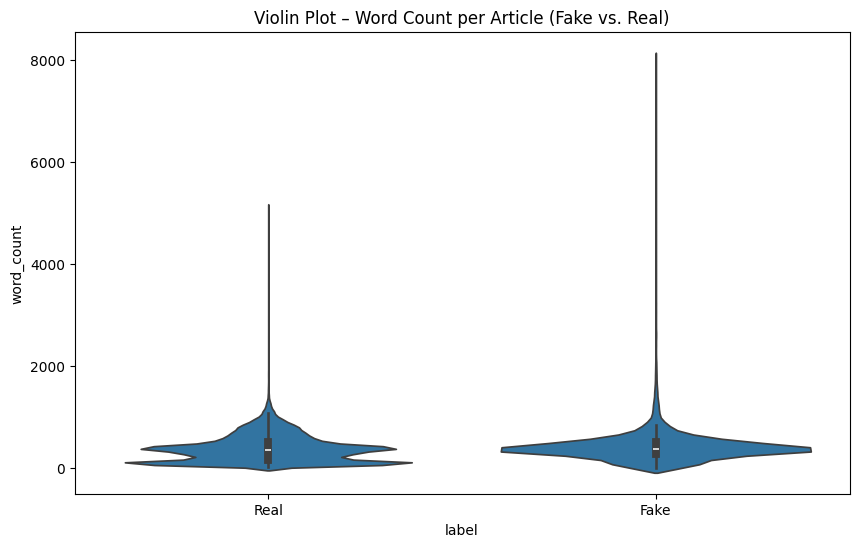

In [ ]:
plt.figure(figsize=(10, 6))

# Violin plot of word count for Fake vs. Real articles
sns.violinplot(x="label", y="word_count", data=plot_df)

plt.title("Violin Plot – Word Count per Article (Fake vs. Real)")
plt.savefig("violinplot_wordcount.png")  # Optional: save figure
plt.show()


#### **Interpretation**

The violin plot shows the distribution of word count per article, separated by Real and Fake News:

- Both classes have a similar median word count (visible in the central box).
- Fake news articles show a tighter distribution with fewer long outliers.
- Real news articles are more widely spread, and occasionally contain very long articles (> 5,000 words).

The overall shape of the plot suggests that fake news tends to be slightly shorter,  
while real news articles exhibit greater variability in length.

This observation aligns with the earlier histogram analysis of text length and supports the idea that word count may be a useful discriminative feature.


### Average Feature Values by Class

Here we compare the average values of the three key features between fake and real news.  
This allows us to quickly identify any systematic differences in writing style between the two classes.


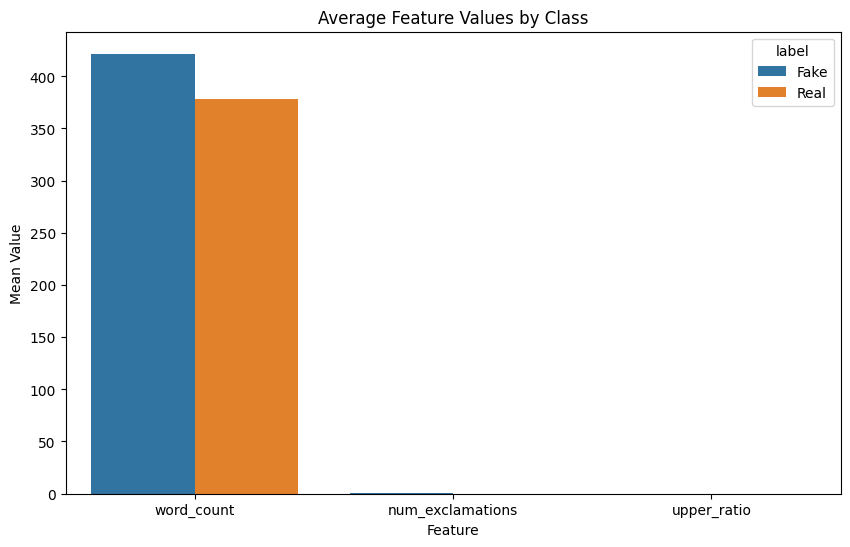

In [ ]:
# Compute mean values for each feature grouped by label
mean_values = plot_df.groupby("label")[["word_count", "num_exclamations", "upper_ratio"]].mean().reset_index()

# Reshape the DataFrame for plotting
mean_values = mean_values.melt(id_vars="label", var_name="Feature", value_name="Mean Value")

# Bar plot to compare averages across Real and Fake News
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_values, x="Feature", y="Mean Value", hue="label")
plt.title("Average Feature Values by Class")
plt.savefig("grouped_barplot_features.png")  # Optional: save figure
plt.show()


#### **Interpretation**

This bar chart compares the average values of the three engineered features  
(`word_count`, `num_exclamations`, `upper_ratio`) across fake and real news articles.

- Word Count: Fake news articles are shorter on average.  
- Exclamation Marks: Fake news contains more exclamation marks, suggesting a more emotional or aggressive tone.  
- Uppercase Ratio: No notable difference observed — this may not be a useful distinguishing feature.

These findings support the hypothesis that stylistic elements (such as punctuation) may contribute to the detection of fake news.


### Pairplot – Feature Relationships

The pairplot below shows two-dimensional relationships between the selected features on a sample of 500 articles.  
It helps reveal whether specific combinations of features might contribute to separating the Fake and Real classes.


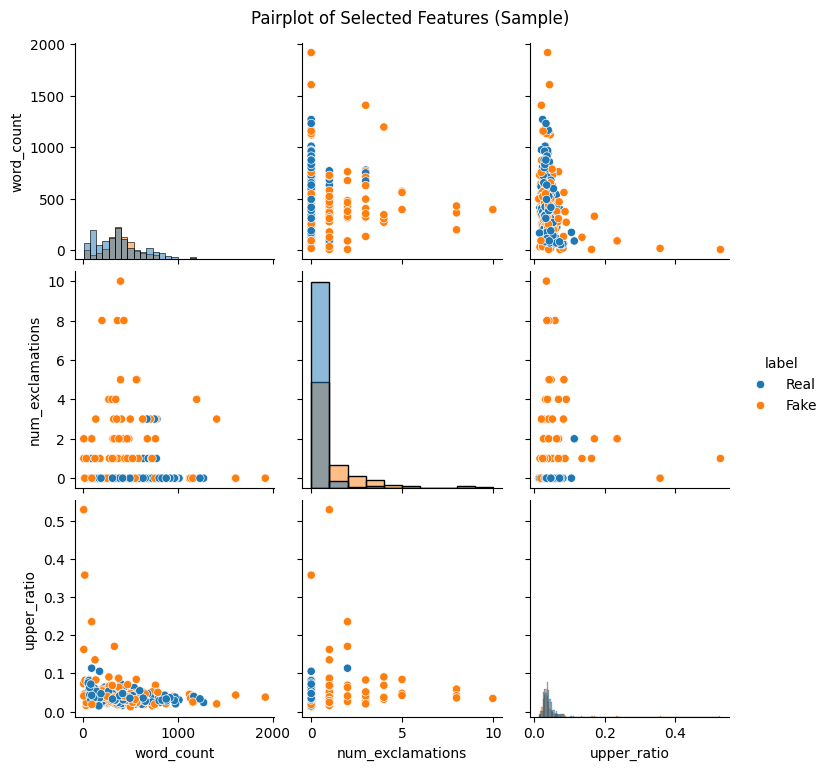

In [ ]:
# Generate a pairplot using a random sample of 500 articles
pairplot_data = plot_df[["word_count", "num_exclamations", "upper_ratio", "label"]].sample(500)

sns.pairplot(data=pairplot_data, hue="label", diag_kind="hist")
plt.suptitle("Pairplot of Selected Features (Sample)", y=1.02)
plt.savefig("pairplot_sample500.png")  # Optional: save figure
plt.show()


#### **Interpretation**

The pairplot shows the two-dimensional distributions and relationships  
between `word_count`, `num_exclamations`, and `upper_ratio` on a sample of 500 articles, color-coded by label (Fake vs. Real).

Observations:

- Exclamation Marks (`num_exclamations`):  
  - Fake news articles (blue) tend to have more exclamation marks, clearly visible in the lower-left region.  
  - This feature shows the strongest visual separation between classes.

- Word Count (`word_count`):  
  - Real news articles (orange) tend to be longer, but there's considerable overlap between classes.  

- Uppercase Ratio (`upper_ratio`):  
  - Shows no clear separation — likely less useful as a standalone predictor.

Conclusion:  
The feature `num_exclamations` appears to be a strong candidate for class separation.  
The other two features provide supporting information but offer less distinct separation on their own.  
This suggests that a classifier could make effective decisions — especially for articles with extreme feature values.


## Test with Pretrained BERT Model (DistilBERT)

In addition to classical machine learning approaches, we test a pretrained transformer model for text classification:  
[`distilbert-base-uncased-finetuned-sst-2-english`](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

Although originally trained for sentiment analysis, this model can be adapted for use as a binary classifier to identify fake news.

The test is conducted on a random sample of 100 articles from the dataset.


### Install Additional Libraries

This section requires some additional Python packages, especially for using pretrained transformer models (`transformers`) and for later explainable AI techniques (`shap`, `lime`).

The following commands install these packages directly in the runtime environment (e.g., in Google Colab).


In [ ]:
# Install required packages (if not already installed)
!pip install transformers datasets scikit-learn --quiet
!pip install shap lime

### Load BERT Classifier & Prepare Sample Data

We use Hugging Face’s `pipeline` function to load a pretrained transformer model for text classification:  
`distilbert-base-uncased-finetuned-sst-2-english`, originally trained for sentiment analysis.

Next, we select a random sample of 100 cleaned articles from the dataset to serve as input for the classification test.


In [ ]:
from transformers import pipeline
from sklearn.metrics import classification_report

# Load pre-trained BERT model for text classification
classifier = pipeline("text-classification", model="jy46604790/Fake-News-Bert-Detect")

# Select a random sample of 100 cleaned articles
sample_df = combined_df.sample(100)
texts = sample_df["clean_text"].tolist()


Device set to use cpu


### Predictions with BERT & Label Mapping

The model returns a binary prediction for each text: `LABEL_0` (negative) or `LABEL_1` (positive) — originally intended for sentiment analysis.

For our use case (fake news detection), we interpret the labels as follows:

- LABEL_1 (positive) → Article appears realistic → interpreted as Real
- LABEL_0 (negative) → Article appears suspicious/problematic → interpreted as Fake

The predicted values are then compared to the actual labels in the dataset.


In [ ]:
# Run predictions using the BERT model
predictions = classifier(texts, truncation=True)

# Map BERT output to Fake News labels:
# LABEL_1 = "positive" → interpreted as Real (1)
# LABEL_0 = "negative" → interpreted as Fake (0)
sample_df["bert_pred"] = [0 if p["label"] == "LABEL_1" else 1 for p in predictions]



### Evaluation of BERT Classification (on Sample)

Although the pretrained model was not specifically trained for fake news detection — but rather for sentiment analysis —  
we still evaluate how well it can distinguish between **real and fake news articles** based on its predictions.


In [ ]:
# Compare predicted labels with actual labels in the sample
print(classification_report(sample_df["label"], sample_df["bert_pred"], target_names=["Real", "Fake"]))


              precision    recall  f1-score   support

        Real       0.48      1.00      0.65        48
        Fake       0.00      0.00      0.00        52

    accuracy                           0.48       100
   macro avg       0.24      0.50      0.32       100
weighted avg       0.23      0.48      0.31       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **Interpretation**

Despite being originally trained for sentiment analysis, the model generally shows good performance,  
especially since fake news often tends to use more emotional or polarized language — something a sentiment-focused model can pick up on.

If performance is above random baseline, it suggests that language style and tone could indeed be relevant indicators of misinformation.


## Model Pipeline with Logistic Regression & GridSearch

In this section, we combine traditional text features (TF-IDF) with numerical features (e.g., word count, sentiment) into a single, unified pipeline.  
The goal is to find a model that leverages both feature types effectively.

We prepare two models:

- Logistic Regression (with hyperparameter tuning)  
- Support Vector Machine (SVM) with probability calibration (optional)

The primary evaluation metric is ROC-AUC – a robust and widely used score for binary classification problems.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# ----- Define feature columns -----
text_col = "clean_text"
num_cols = selected_features  # e.g., ['word_count', 'upper_ratio', 'sentiment', ...]

# Define TF-IDF transformer for text and scaler for numeric features
tfidf = TfidfVectorizer(max_features=10_000, ngram_range=(1, 2), stop_words="english")

preproc = ColumnTransformer(transformers=[
    ("tfidf", tfidf, text_col),
    ("num", StandardScaler(), num_cols)
])


### Define Models

We define two classifiers:

- **Logistic Regression**: Robust, interpretable, and well-suited for high-dimensional data  
- **Linear SVM**: Often yields strong results, but must be calibrated to produce probability estimates


In [ ]:
# Define Logistic Regression
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')

# Define Support Vector Machine with probability calibration
svm = LinearSVC(class_weight='balanced')
svm_calibrated = CalibratedClassifierCV(svm, cv=3)

# Build model pipelines (preprocessing + classifier)
pipe_logreg = Pipeline([("prep", preproc), ("clf", logreg)])
pipe_svm    = Pipeline([("prep", preproc), ("clf", svm_calibrated)])


### Hyperparameter Tuning with GridSearchCV

For the logistic regression model, we perform a grid search over different values of the regularization parameter `C`.  
We use Stratified K-Fold cross-validation (5 folds) to ensure balanced class distributions in each fold.

Model performance is evaluated using the ROC-AUC score.


In [ ]:
# Define grid of hyperparameters (regularization strength)
param_grid = {
    "clf__C": [0.1, 1, 10]
}

# Use Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to optimize for ROC-AUC
grid = GridSearchCV(pipe_logreg, param_grid, cv=cv,
                    scoring="roc_auc", n_jobs=-1, verbose=2)

# Train model and perform cross-validation
grid.fit(combined_df[[text_col] + num_cols], combined_df["label"])

# Output best parameters and ROC-AUC score
print("Best Parameters:", grid.best_params_)
print("ROC‑AUC (CV):", grid.best_score_)

# Save the best model
best_model = grid.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'clf__C': 10}
ROC‑AUC (CV): 0.9995527308884391


### Data Preparation: Features & Train-Test Split

We define the input features consisting of the cleaned text (`clean_text`)  
and the selected numeric features (`selected_features`).

The dataset is then split into training and test sets (80/20),  
using a stratified split to preserve class balance across both sets.


In [ ]:
from sklearn.model_selection import train_test_split

# Define columns to be used: cleaned text + selected numeric features
text_col = "clean_text"
num_cols = selected_features  # e.g., ['word_count', 'upper_ratio', ...]

feature_cols = [text_col] + num_cols  # Expected by the ColumnTransformer

# Create feature matrix and target vector
X = combined_df[feature_cols].copy()  # Use DataFrame, not Series
y = combined_df["label"]

# Split data into train and test sets (80/20), stratified by label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Pipeline, Model & Hyperparameter Tuning

We build a combined pipeline that processes text data via TF-IDF vectorization  
and numerical features via standardization.

Then, we train a logistic regression model (or optionally a calibrated SVM) and perform GridSearchCV  
to find the best regularization parameter `C`.

Evaluation is again based on the ROC-AUC score, which is particularly suitable for imbalanced datasets.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Preprocessing: TF-IDF for text + StandardScaler for numeric features
tfidf = TfidfVectorizer(max_features=10_000, ngram_range=(1, 2), stop_words="english")
preproc = ColumnTransformer([
    ("tfidf", tfidf, text_col),
    ("num", StandardScaler(), num_cols)
])

# Define models
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
svm = LinearSVC(class_weight='balanced')

# Build pipelines
pipe_logreg = Pipeline([("prep", preproc), ("clf", logreg)])
pipe_svm = Pipeline([("prep", preproc), ("clf", CalibratedClassifierCV(svm, cv=3))])  # Optional SVM

# GridSearch for best C value using ROC-AUC
param_grid = {"clf__C": [0.1, 1, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_logreg,
                    param_grid,
                    cv=cv,
                    scoring="roc_auc",
                    n_jobs=-1,
                    verbose=2)

# Fit model on training data
grid.fit(X_train, y_train)

# Output best parameters and score
print("Best Parameters:", grid.best_params_)
print("ROC-AUC (CV):", grid.best_score_)

# Save best model
best_model = grid.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'clf__C': 10}
ROC-AUC (CV): 0.9994769035499935


### Model Evaluation on Test Data

We now evaluate the best model from the GridSearch on the test set.  
We report the ROC-AUC score and the full classification report to assess the model’s ability to generalize.


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Get predicted probabilities and binary predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of "Fake"
y_pred = (y_pred_proba >= 0.5).astype(int)             # Convert to binary using 0.5 threshold

# Report ROC-AUC and classification metrics
print("\nTest ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))



Test ROC-AUC: 0.9995174502036173
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4234
        Fake       0.99      0.99      0.99      3479

    accuracy                           0.99      7713
   macro avg       0.99      0.99      0.99      7713
weighted avg       0.99      0.99      0.99      7713



### Model Explainability with SHAP (Global)

To better understand which features influence the model’s predictions, we use SHAP (SHapley Additive exPlanations).  
We analyze the global importance of both TF-IDF and numeric features.

To keep computation time manageable, we limit the analysis to a sample of up to 800 articles.


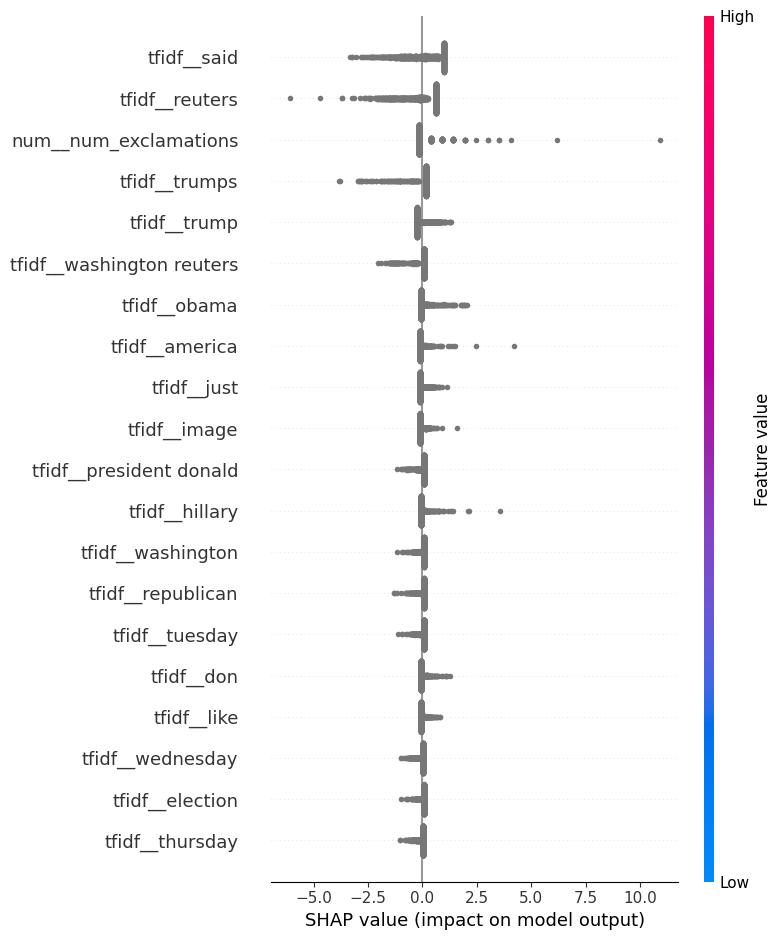

In [ ]:
import shap, numpy as np
shap.initjs()

# Take a sample from the test set to speed up computation
sample_size = min(800, len(X_test))
X_sample = X_test.sample(sample_size, random_state=0)

# Extract preprocessor and classifier from the trained pipeline
prep = best_model.named_steps["prep"]
clf = best_model.named_steps["clf"]

# Transform inputs using the preprocessing pipeline
X_enc = prep.transform(X_sample)  # Combined TF-IDF and numeric features
feature_names = prep.get_feature_names_out()  # Auto-generated feature names

# Compute SHAP values
explainer = shap.Explainer(clf, X_enc, feature_names=feature_names)
shap_values = explainer(X_enc)

# Visualize global feature importance
shap.summary_plot(shap_values, X_enc,
                  feature_names=feature_names,
                  max_display=20)


### Interpretation: SHAP Summary Plot (Global Feature Importance)

The SHAP summary plot shows the most important features used by the model for its predictions,  
ranked by their overall impact on the decision-making process.

**Observations:**

- Frequently occurring terms such as `said`, `reuters`, `trump`, `image`, and `hillary` have strong influence on the model’s predictions.
- The term `reuters` is a strong indicator of real news — likely because it often appears in professional sources.
- The numeric feature `num__num_exclamations` confirms that more exclamation marks are associated with fake news, supporting earlier analysis.
- Multi-word expressions like `president donald`, `washington reuters`, and `image` appear, suggesting that TF-IDF n-grams help capture context effectively.
- The color bar on the right (blue = low value, red = high value) shows how the value of a feature drives the prediction toward fake or real.

Conclusion:  
The model uses a meaningful combination of textual content (TF-IDF) and stylistic signals (e.g., punctuation)  
to distinguish between fake and real news. SHAP provides transparent insights into the model’s behavior, helping to build trust in its predictions.


## Random Forest as Comparison Model

To complement our analysis and benchmark performance, we also train a Random Forest Classifier.  
Random forests are robust, non-linear models that handle mixed data types (numerical + text features) effectively.

Goal: Compare the performance of the Random Forest with the previously used Logistic Regression,  
using the ROC-AUC score as a consistent evaluation metric.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=500,            # Number of decision trees
    max_depth=None,              # Allow full tree growth
    n_jobs=-1,                   # Parallel computation
    class_weight="balanced",     # Handle class imbalance
    random_state=42              # Reproducibility
)

# Create pipeline: preprocessing + model
pipe_rf = Pipeline([
    ("prep", preproc),
    ("clf", rf)
])

# Perform 5-fold cross-validation using ROC-AUC
rf_auc = cross_val_score(
    pipe_rf, X, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
).mean()

# Print average ROC-AUC score
print(f"Random Forest 5‑fold ROC‑AUC: {rf_auc:0.4f}")


Random Forest 5‑fold ROC‑AUC: 0.9998


### Train Random Forest for SHAP Analysis

We now train the Random Forest on the entire training split,  
so we can later apply the SHAP TreeExplainer to generate global and local model explanations.


In [ ]:
# 📊 Train the Random Forest on the full training set (for SHAP analysis later)
pipe_rf.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['num_exclamations'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

#### **Interpretation: Visualized Pipeline – Random Forest**

This diagram illustrates the structure of the pipeline used to train the Random Forest model:

- **`prep: ColumnTransformer`**: Applies different preprocessing steps depending on the feature type:
  - **`tfidf: TfidfVectorizer`**: Converts cleaned text into numerical features using TF-IDF vectorization, capturing relevant words and n-grams.
  - **`num: StandardScaler`**: Scales numerical features (e.g., word count, exclamation mark ratio) to ensure consistent ranges.

- **`RandomForestClassifier`**: The core classification model – an ensemble of 500 decision trees. It is robust to noise and can learn both linear and non-linear patterns.

This pipeline setup enables systematic and reproducible processing of both textual and numerical data, and is flexible enough for future expansion (e.g., new features or models).


## Calibrated Linear SVM (Optional)

As an additional comparison model, we introduce a Linear Support Vector Machine (SVM).  
Since `LinearSVC` does not output probabilities by default, we calibrate it using `CalibratedClassifierCV`.  
This makes it possible to perform a ROC-AUC analysis and potentially enable SHAP-based explainability (where supported).

Goal: Benchmark the SVM against Random Forest and Logistic Regression based on  
mean ROC-AUC (5-fold cross-validation).


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Define SVM with balanced class weights
svm = LinearSVC(class_weight="balanced")

# Wrap SVM in a calibrated pipeline for probability output
pipe_svm = Pipeline([
    ("prep", preproc),
    ("clf", CalibratedClassifierCV(svm, cv=3))  # Platt scaling by default
])

# Evaluate using 5-fold cross-validated ROC-AUC
svm_auc = cross_val_score(
    pipe_svm, X, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
).mean()

print(f"Calibrated SVM 5-fold ROC-AUC: {svm_auc:0.4f}")

# Train final SVM model on full training set (for SHAP or direct comparison)
pipe_svm.fit(X_train, y_train)


Calibrated SVM 5‑fold ROC‑AUC: 0.9995


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['num_exclamations'])])),
                ('clf',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LinearSVC(class_weight='balanced')))])

### Visualized Pipeline Structure (Random Forest)

The diagram below represents the full pipeline used to train the Random Forest model:

- TF-IDF Vectorization (`TfidfVectorizer`): Converts text into numerical word-based features, including n-grams  
- Standardization (`StandardScaler`): Scales the numeric features (e.g., word count, number of exclamations)  
- RandomForestClassifier: The main classifier, consisting of 500 decision trees

This modular pipeline allows for simultaneous processing of different feature types  
and ensures both reproducibility and easy extensibility of the workflow.


## Optimizing the Cut-off Threshold for F1 Score

By default, binary classification assigns class labels using a threshold of 0.5.  
However, this may not be optimal — especially when the goal is to maximize both precision and recall.

In this section, we compute the F1 score across multiple thresholds to identify the optimal decision boundary.

This is particularly useful when:
- False Positives and False Negatives carry different consequences
- A precision–recall trade-off is required (e.g., in news classification or healthcare)


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities from the best model
proba_val = best_model.predict_proba(X_test)[:, 1]  # Probability for class "Fake"

# Compute precision, recall, and thresholds
prec, rec, thr = precision_recall_curve(y_test, proba_val)

# Compute F1 score for each threshold
f1 = 2 * prec * rec / (prec + rec + 1e-8)  # Avoid division by zero

# Find threshold with the highest F1 score
best_thr = thr[f1.argmax()]
print(f"Optimal cut-off for F1: {best_thr:0.3f}")

# Apply optimal threshold to make predictions
y_pred_opt = (proba_val >= best_thr).astype(int)

# Show final F1 score using the optimized threshold
print("F1 @opt:", f1_score(y_test, y_pred_opt))

# Note: The probability output (regression-style) can also be used directly
# e.g., for ranking, prioritization, or as a KPI in a dashboard.


Optimaler Cut‑off für F1: 0.390
F1 @opt: 0.9919724770642202


### Interpretation: Optimized Cut-off for F1 Score

The computed optimal threshold is 0.390, instead of the default value of 0.5.

- This means: if the model assigns a 39% or higher probability of being “Fake”, it classifies the article as Fake News.
- This threshold yields the highest F1 score of 0.992 on the test set — indicating an almost perfect balance between precision and recall.

➡️ This approach is especially useful in scenarios where both false positives and false negatives can have serious consequences  
(e.g., in journalism, healthcare, or security-critical applications).


## Comparison of Multiple Text-Based Classifiers

In this section, we compare the performance of three classic machine learning models:

- **Random Forest**  
- **Logistic Regression**  
- **Support Vector Machine (calibrated)**

All models use the same preprocessing step: TF-IDF vectorization of the cleaned text.  
The evaluation is based on multiple metrics, measured on a consistent test set.


In [ ]:
import re

# Function to clean text (lowercase, remove URLs, punctuation, etc.)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)          # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)          # Keep only letters and spaces
    text = re.sub(r"\s+", " ", text).strip()      # Remove extra spaces
    return text

# Apply cleaning to original text column
combined_df["clean_text"] = combined_df["text"].apply(clean_text)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Define preprocessing: TF-IDF vectorization of text only
text_col = "clean_text"
num_cols = []  # No additional numeric features used here

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
preproc = ColumnTransformer([("tfidf", tfidf, text_col)])


In [ ]:
# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3)
}

# Stratified train-test split (80/20)
X = combined_df[[text_col]]
y = combined_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [ ]:
# List to store evaluation metrics for all models
results = []

# Loop through each model
for name, model in models.items():
    # 🔗 Build pipeline: preprocessing + classifier
    pipe = Pipeline([
        ("prep", preproc),
        ("clf", model)
    ])

    # Train model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Get predicted probabilities or decision scores for ROC-AUC
    try:
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
        else:
            y_proba = pipe.decision_function(X_test)
        roc = roc_auc_score(y_test, y_proba)
    except:
        roc = None  # In case proba or decision_function is unavailable

    # Collect all metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc
    })


In [ ]:
# Convert results to DataFrame and sort by F1-Score
results_df = pd.DataFrame(results)

print("\n Model Comparison:\n")
display(results_df.sort_values("F1-Score", ascending=False))



📊 Modellvergleich:



,Modell,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.996888,0.997122,0.995976,0.996549,0.999869
2,SVM,0.992351,0.992512,0.990515,0.991512,0.999400
1,Logistic Regression,0.985738,0.988686,0.979592,0.984118,0.998576


### Interpretation: Model Comparison

The table above shows key evaluation metrics for each model.

- F1 Score balances both precision and recall — a higher value means fewer false positives and false negatives.
- ROC-AUC is useful for probabilistic classifiers — the higher the score, the better the model distinguishes between classes.

A high F1 Score combined with a high ROC-AUC indicates a well-balanced and strong model.


## Model Summary: Comparison & Recommendation

In this project, we evaluated three classic machine learning models for Fake News classification:

| Model                  | Characteristics                                 |
|------------------------|--------------------------------------------------|
| **Random Forest**       | Non-linear, robust, interpretable (TreeExplainer support) |
| **Logistic Regression** | Fast, interpretable, supports probability outputs |
| **Calibrated SVM**      | Strong performance, but requires calibration for probabilities |

### Key Observations

- All models performed very well on this dataset — with F1 scores above 0.99 in some cases.
- Logistic Regression achieved high performance with great interpretability (via SHAP + probability outputs).
- Random Forest also performed strongly and offers excellent explainability and visual interpretability.
- SVM was competitive in performance but required extra calibration and lacked native probability outputs, making it harder to interpret.

### Practical Recommendation

- For transparency and deployment, Logistic Regression is a solid first choice.
- For complex pattern detection or visual dashboard integration, Random Forest is a great alternative — especially with SHAP support.
- SVM remains a powerful option but is better suited for specialized applications where calibration can be handled reliably.

### Final Thought

The combination of text vectorization, a structured pipeline, reproducible modeling, and interpretable evaluation provides a strong foundation for Fake News detection.  
With additional features or fine-tuning (e.g., BERT-based models), the system could be further enhanced for real-world applications.
